In [30]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn import metrics

from keras.models import Sequential
from keras.layers import Dense, Dropout, regularizers
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras import optimizers


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence


import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
data_length = 24000
stock = '11869'
gdf_filename_pattern = 'gdf_{}_r{}_s{}_K50'
gdf_parameters = [(0.1, 0.1), (0.01, 0.1), (0.1, 0.5), (0.01, 0.5), (0.25, 0.25)]

In [32]:
gdf_dfs = []
for r, s in gdf_parameters:
    gdf_dfs.append(gdf_pca.SvmGdfResults(
        stock,  r=r, s=s, data_length=data_length, data_dir='../../data/data_gdf',
        reg_data_dir='../../data/prepared',
        gdf_filename_pattern=gdf_filename_pattern))

In [33]:
df = gdf_dfs[4].df
df_test = gdf_dfs[4].df_test
n_components = gdf_dfs[4].get_pca('pca_n_gdf_que_prev').n_components_

class_weights = gdf_dfs[4].get_classes_weights()
print(n_components, class_weights)

8 {0.0: 0.6839199202051867, 1.0: 1.8592872361030408}


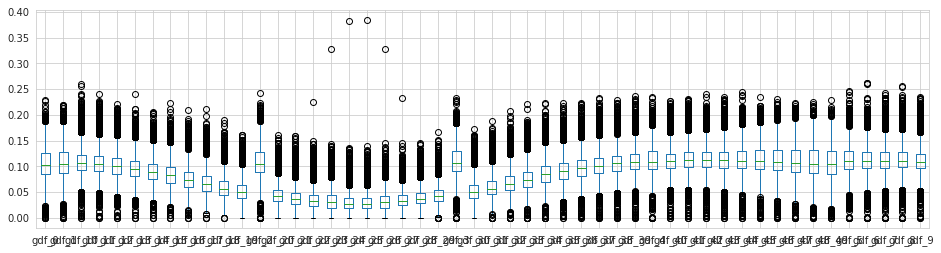

In [34]:
df[[c for c in df.columns if 'gdf' in c]].boxplot(figsize=(16, 4))

In [35]:
from keras import backend as K
def as_keras_metric(method):
    import functools
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper
import tensorflow as tf

auc_roc = as_keras_metric(tf.metrics.auc)

def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [8]:
## With validation

In [39]:
n_steps = 4
gdf_df = gdf_dfs[4]
feature = 'pca_n_gdf_que'
pca = gdf_df.get_pca(feature)

In [48]:
train_x = pca.transform(gdf_df.df[gdf_df.feature_columns_dict[feature]])
train_y = gdf_df.df['mid_price_indicator']
test_x = pca.transform(gdf_df.df_test[gdf_df.feature_columns_dict[feature]])
test_y = gdf_df.df['mid_price_indicator']

#numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))
print(train_x.shape, test_x.shape)

(19199, 10, 1) (4799, 10, 1)


In [49]:
def get_model():
    model = Sequential()
    model.add(LSTM(16, activation='sigmoid', input_shape=(10, 1), return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[matthews_correlation, auc_roc])
    return model

In [53]:
m = get_model()
m.fit(train_x, train_y, verbose=1, batch_size=512, epochs=20, shuffle=False)

Epoch 1/20
19199/19199 [==============================] - 5s 274us/step - loss: 0.6362 - matthews_correlation: 0.0000e+00 - auc: 0.4936
Epoch 2/20
19199/19199 [==============================] - 0s 15us/step - loss: 0.5887 - matthews_correlation: 0.0000e+00 - auc: 0.4996
Epoch 3/20
19199/19199 [==============================] - 0s 15us/step - loss: 0.5823 - matthews_correlation: 0.0000e+00 - auc: 0.5000
Epoch 4/20
19199/19199 [==============================] - 0s 19us/step - loss: 0.5822 - matthews_correlation: 0.0000e+00 - auc: 0.4993
Epoch 5/20
19199/19199 [==============================] - 0s 17us/step - loss: 0.5822 - matthews_correlation: 0.0000e+00 - auc: 0.4982
Epoch 6/20
19199/19199 [==============================] - 0s 16us/step - loss: 0.5822 - matthews_correlation: 0.0000e+00 - auc: 0.4972
Epoch 7/20
19199/19199 [==============================] - 0s 17us/step - loss: 0.5822 - matthews_correlation: 0.0000e+00 - auc: 0.4966
Epoch 8/20
19199/19199 [==============================

In [54]:
pred = m.predict_classes(train_x)
metrics.matthews_corrcoef(train_y, pred)

0.0